## <span style="color: pink;"> Importing Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import itertools
from sklearn.neighbors import NearestNeighbors
import pickle
from rapidfuzz import process,fuzz

%matplotlib inline

## <span style="color: pink;"> Importing Data </span>

#### <span style="color: #b4eb34;"> This is where we import the two datsets that were created by GroupLens </span>

In [2]:
movies = pd.read_csv(r"C:/Users/Mandula Thrimanne/OneDrive/Documents/Personal/Medium Articles/Movie Recommendation System/Raw Data/ml-latest-small/movies.csv")
ratings = pd.read_csv(r"C:/Users/Mandula Thrimanne/OneDrive/Documents/Personal/Medium Articles/Movie Recommendation System/Raw Data/ml-latest-small/ratings.csv")

In [3]:
# getting a glimpse of the data

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# getting a glimpse of the data

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print(ratings['userId'].nunique())
print(ratings['movieId'].nunique())

610
9724


## <span style="color: pink;"> Data Cleaning </span>

#### <span style="color: #b4eb34;"> The data cleaning section is mainly handling the clening of the title column. Movie names that start with "The" is presenter in an unusual way in the dataset. Eg: American President, The (1995). For this example, we want the title to be "The American President (1995) at the end of data cleaning" </span>

In [6]:
# cleaning the ", The \(" in movie title

movies[movies['title'].str.contains(', The \(')]

,movieId,title,genres
10,11,"American President, The (1995)",Comedy|Drama|Romance
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
49,54,"Big Green, The (1995)",Children|Comedy
52,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
...,...,...,...
8741,127180,"Story of Film: An Odyssey, The (2011)",Documentary
8808,130578,"Gunman, The (2015)",Action|Thriller
9018,140523,"Visit, The (2015)",Comedy|Horror
9120,145935,"Peanuts Movie, The (2015)",Adventure|Animation|Children|Comedy


In [7]:
# fixing the titles of movies to keep it consistent with the rest of the movies

# Fix titles by moving ", The" to the front
movies['title'] = movies['title'].apply(lambda x: 'The ' + x.replace(', The', '') if ', The' in x else x)

In [8]:
# checking if the cleaning happened in the way we intended

movies[movies['title'].str.contains('The ')]

,movieId,title,genres
10,11,The American President (1995),Comedy|Drama|Romance
28,29,The City of Lost Children (Cité des enfants pe...,Adventure|Drama|Fantasy|Mystery|Sci-Fi
46,50,The Usual Suspects (1995),Crime|Mystery|Thriller
49,54,The Big Green (1995),Children|Comedy
52,58,"The Postman (Postino, Il) (1994)",Comedy|Drama|Romance
...,...,...,...
9717,188833,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
9724,190183,The Darkest Minds (2018),Sci-Fi|Thriller
9732,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi
9733,193567,anohana: The Flower We Saw That Day - The Movi...,Animation|Drama


## <span style="color: pink;"> Summary Statistics </span>

#### <span style="color: #b4eb34;"> The summary statistics section aims to find out how many users on average have rated movies and how many movies on average were rated by users </span>

In [9]:
# Calculate how many movies were rated by each user
movies_per_user = ratings.groupby('userId')['movieId'].count()

# Calculate how many users rated each movie
users_per_movie = ratings.groupby('movieId')['userId'].count()


**Note: Groupbys only contain indexes(movies or users) with alteast one result. Therefore, a seperate fileration is not required.**

In [10]:
movies_per_user

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

In [11]:
users_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: userId, Length: 9724, dtype: int64

In [12]:
# Calculate mean and median

mean_movies_per_user = movies_per_user.mean()
median_movies_per_user = movies_per_user.median()

mean_users_per_movie = users_per_movie.mean()
median_users_per_movie = users_per_movie.median()

In [13]:
print(f"Movies rated per user (Mean): {mean_movies_per_user}")
print(f"Movies rated per user (Median): {median_movies_per_user}")
print(f"User ratings per movie (Mean): {mean_users_per_movie}")
print(f"User ratings per movie (Median): {median_users_per_movie}")

Movies rated per user (Mean): 165.30491803278687
Movies rated per user (Median): 70.5
User ratings per movie (Mean): 10.369806663924312
User ratings per movie (Median): 3.0


## <span style="color: pink;"> Data Transformation </span>

#### <span style="color: #b4eb34;"> This section is dedicated to tranforming the data that we currenlty have to a form that can serve as an input to the k nearest neighbors model </span>

- First part of this exercise is to convert the ratings df - which has userId and movieId - into a pivot table. This was the challenge that we had with the larger dataset that had more than 1M ratings. The processing power of my current computer did not allow me to convert that dataframe to a pivot table. 
- The second part converts the pivot table to a sparse matrix. A sparse matrix is a matrix that keeps track of the cordinates of the non-zero values. This is extrememly useful when it comes to storing matrices that have a large number of zeroes. 

#### <span style="color: yellow;"> Coverting the data into a pivot table </span>

In [14]:
# creating the pivot table

final_dataset = ratings.pivot_table(index='movieId',columns='userId',values='rating',fill_value=0)

final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4,0.0,0.0,0,4,0,4.5,0,0,0.0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
2,0,0.0,0.0,0,0,4,0.0,4,0,0.0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
3,4,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
4,0,0.0,0.0,0,0,3,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0
5,0,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0


In [15]:
final_dataset.shape

(9724, 610)

**Note: Final dataset has 9724 movies and 610 users before filteration**

In [16]:
# filter the dataset to avoid any users that didn't rate more than a certain amount and movies that were not rated by a certain number of users

# Filter rows and columns based on the median values we found from above
filtered_movies = users_per_movie[users_per_movie > 10].index
# filtered_users = movies_per_user[movies_per_user > 30].index

# Select only the rows and columns that meet the condition
final_dataset_filtered = final_dataset.loc[filtered_movies,:]
# final_dataset_filtered=final_dataset_filtered.loc[:,filtered_users]


# Output the resulting pivot table
final_dataset_filtered.shape

(2121, 610)

**Note: Final dataset has 2121 movies and 498 users before filteration**

In [17]:
# export a copy to be used in the server

# final_dataset_filtered.to_csv('final_dataset_filtered.csv')

#### <span style="color: yellow;"> Coverting the pivot table to a sparse matrix </span>

In [18]:

csr_data = csr_matrix(final_dataset_filtered.values)

print(csr_data)

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (2118, 600)	4.5
  (2119, 61)	3.5
  (2119, 97)	3.0
  (2119, 152)	0.5
  (2119, 209)	4.5
  (2119, 248)	4.5
  (2119, 379)	0.5
  (2119, 413)	4.5
  (2119, 513)	2.0
  (2119, 514)	4.0
  (2119, 566)	2.0
  (2119, 585)	5.0
  (2119, 595)	3.5
  (2120, 24)	5.0
  (2120, 61)	4.0
  (2120, 97)	5.0
  (2120, 232)	2.5
  (2120, 247)	4.5
  (2120, 248)	5.0
  (2120, 304)	5.0
  (2120, 330)	4.0
  (2120, 337)	1.0
  (2120, 379)	3.0
  (2120, 513)	3.5
  (2120, 585)	4.0


In [19]:
# behind the scenes of a sparse matrix conversion

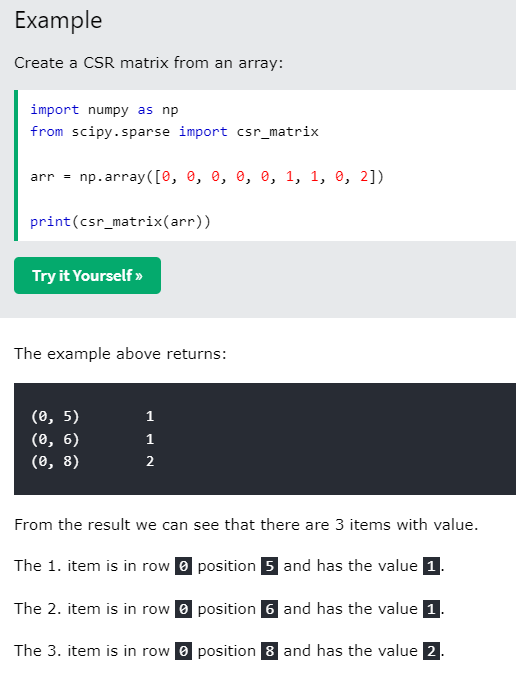

In [20]:
# since csr matrix has a new index from 0 to 2120 for movies, we have to reset the index of final_dataset_filtered

final_dataset_filtered.reset_index(inplace=True)

final_dataset_filtered

userId,movieId,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
0,1,4,0.0,0.0,0,4,0,4.5,0,0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
1,2,0,0.0,0.0,0,0,4,0.0,4,0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
2,3,4,0.0,0.0,0,0,5,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
3,5,0,0.0,0.0,0,0,5,0.0,0,0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0
4,6,4,0.0,0.0,0,0,4,0.0,0,0,...,0.0,3,4,3,0.0,0.0,0,0.0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0,0.0,0.0,0,0,0,0.0,0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2117,176371,0,0.0,0.0,0,0,0,0.0,0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2118,177765,0,0.0,0.0,0,0,0,0.0,0,0,...,4.5,0,0,0,0.0,0.0,0,0.0,0,0.0
2119,179819,0,0.0,0.0,0,0,0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0


In [21]:
# Rename the index from 'userId' to 'csr_index'
final_dataset_filtered.index.name = 'csr_index'

final_dataset_filtered

userId,movieId,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
csr_index,,,,,,,,,,,,,,,,,,,,,
0,1,4,0.0,0.0,0,4,0,4.5,0,0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
1,2,0,0.0,0.0,0,0,4,0.0,4,0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
2,3,4,0.0,0.0,0,0,5,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
3,5,0,0.0,0.0,0,0,5,0.0,0,0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0
4,6,4,0.0,0.0,0,0,4,0.0,0,0,...,0.0,3,4,3,0.0,0.0,0,0.0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0,0.0,0.0,0,0,0,0.0,0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2117,176371,0,0.0,0.0,0,0,0,0.0,0,0,...,4.0,0,0,0,0.0,0.0,0,0.0,0,0.0
2118,177765,0,0.0,0.0,0,0,0,0.0,0,0,...,4.5,0,0,0,0.0,0.0,0,0.0,0,0.0


## <span style="color: pink;"> Model Building + Hyperparameter Tuning </span>

#### <span style="color: #b4eb34;"> This section handles the model creation, model testing, and hyperparameter tuning as well. Therefore, we will not just be building a model but also measuring its performance, and further using that model evaluation metric to find out the best performing model  </span>

- ##### **Prerequisites for testing**: This is where we create a temporary model for testing purposes.
- ##### **Understanding the model output**: This section is dedicated to understanding the "behind-the-scenes" of the model
- ##### **Precision @ K by Genres (Testing)**: We take one scenario of how we plan to compare the relevancy of the input movie and a recommended movie and also conclude the relevancy of the two movies. Since genre was the only substancial info we have on movies, we compare genres of the two movies to measure relevance.
- ##### **Precision @ K by Genres (Complete Loop)**: We create a loop of what we carried out in testing to cover every movie and its relevance with recommended movies.
- ##### **Precision @ K by Genres (Hyperparameter Tuning)**: After we create a complete loop, we hyperparameter tune it to find the best performing parameters to our KNN model. 
- ##### **Precision @ K by Genres across eras**: We found out that the availabilty of ratings across eras is vastly different during part 1 of this project. Hence we want to analyze precision@k across eras to see if that suspected pattern is visible.
- ##### **Creating a final KNN model using the parameters that the highest performing model presented during hyperparameter tuning**: This is the final model that will be used in the server's function


### <span style="color: yellow;">Prerequisites for testing</span>


In [22]:
# Example: Merge ratings and genres data on 'movieId'
ratings_with_genres = pd.merge(ratings, movies, on='movieId', how='left')

In [23]:
ratings_with_genres

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,The Usual Suspects (1995),Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [24]:
#Building a KNN model 
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(csr_data)

# Number of neighbors to retrieve
K = 10

# Retrieve the nearest neighbors for each movie
distances, indices = knn.kneighbors(csr_data, n_neighbors=K+1)

### <span style="color: yellow;">Understanding the model output</span>

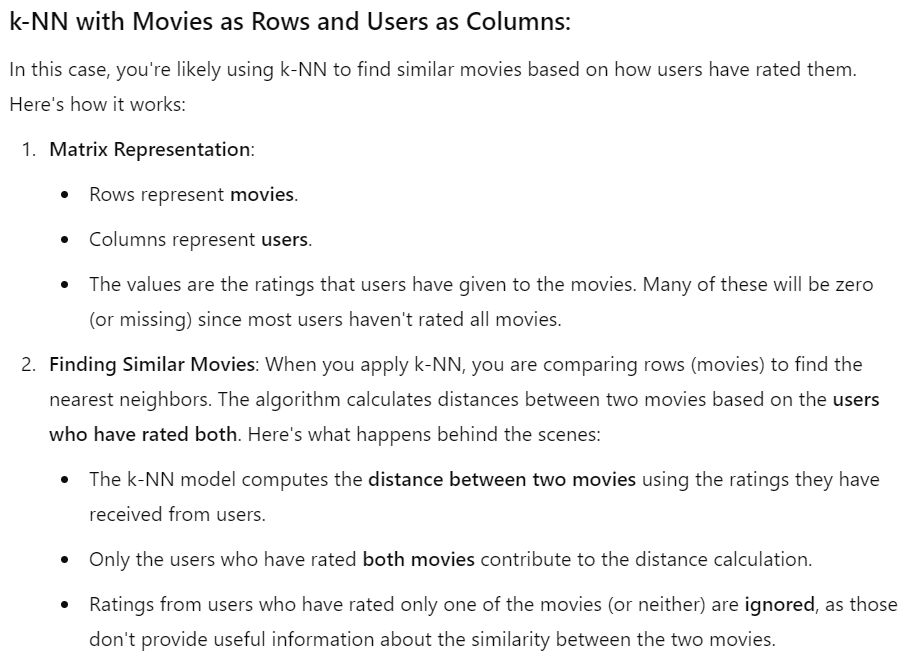
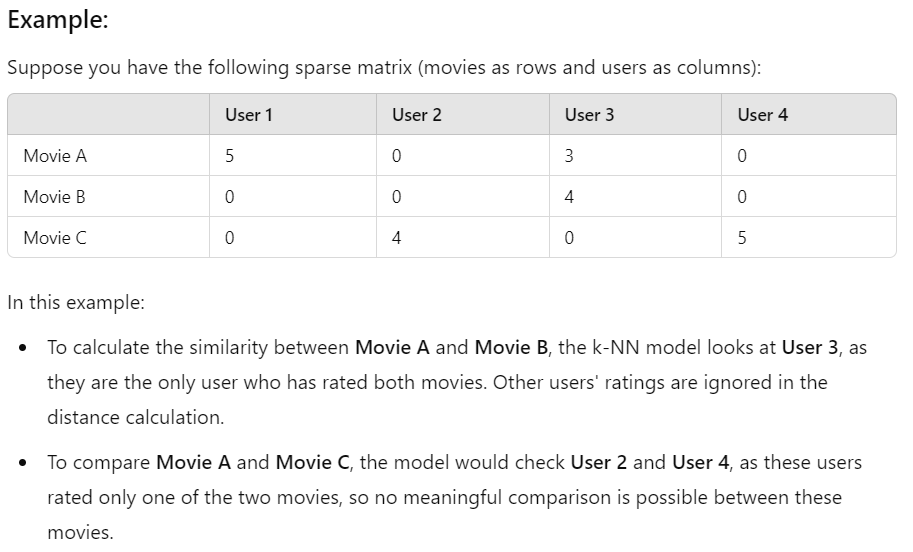
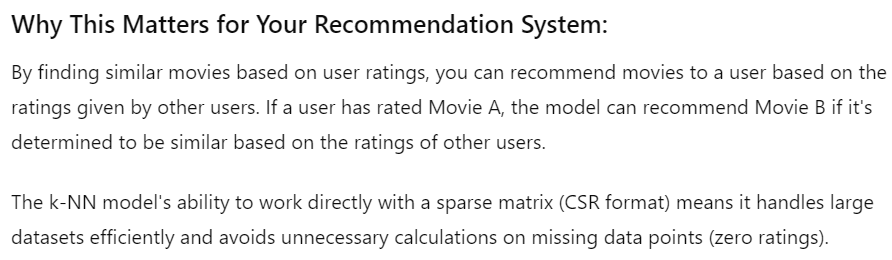

### *Here's also a larger example:*

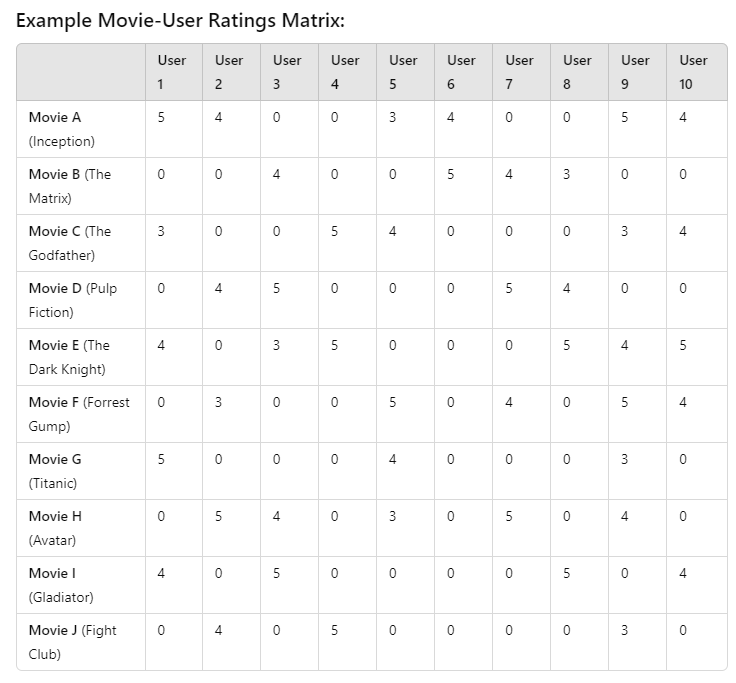
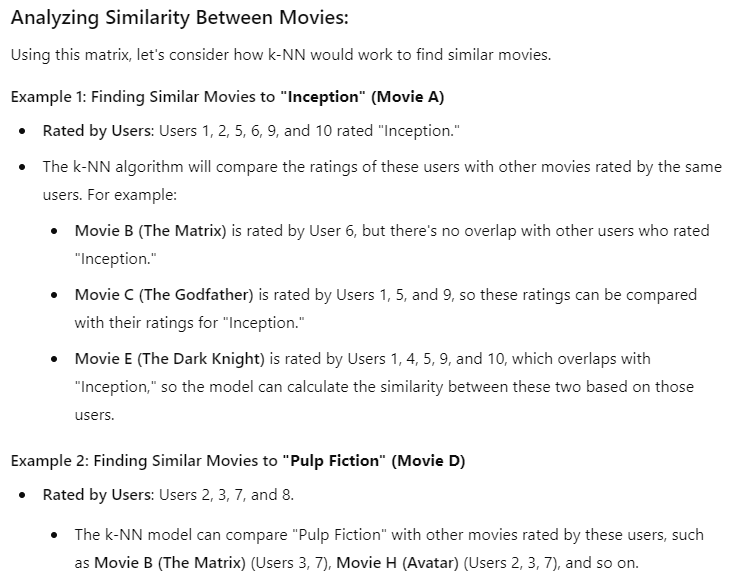
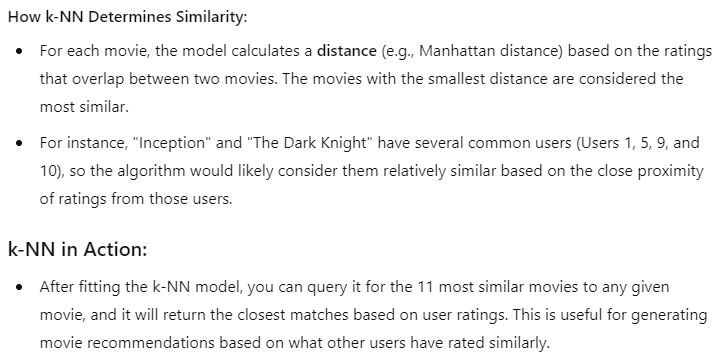

### <span style="color: yellow;">Precision @ K by Genres (Testing)</span>

In [25]:
# inputs for the function

# the below csr_index is selected by a range from 0 to 2120


## assign a movie_index
csr_index = 6

## gather the movie_id using the csr_index
movie_id = ratings_with_genres.iloc[csr_index]['movieId']

## gather the genres of the movie that's being tested
input_movie_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == movie_id, 'genres'].str.split('|').values[0])

## find the recommended movies to the test movie - which will provide 10 recommendations excluding the tested movie itself
recommended_items = indices[csr_index]



In [26]:
# inside the function

# temp variable
recommended_item = recommended_items[3]

## gathering the movie id of the recommended movie using the csr index
recommended_item_movie_id = ratings_with_genres.iloc[recommended_item]['movieId']

## find the genres of the recommended movies ( the set function in here makes sure there are no duplicates across genres)
rec_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == recommended_item_movie_id, 'genres'].str.split('|').values[0])

In [27]:
# genres of the test movie

input_movie_genres

{'Adventure', 'Comedy', 'Crime', 'Romance'}

In [28]:
#genres of the recommended movie

rec_genres

{'Comedy', 'Crime', 'Thriller'}

In [29]:
# Calculate the intersection between the two sets
common_genres = input_movie_genres & rec_genres

if len(common_genres) / len(input_movie_genres) >= 0.5:
    print("Relevant Recommendation")
else:
    print("Not Relevant")

Relevant Recommendation


### <span style="color: yellow;">Precision @ K by Genres (Complete Loop)</span>

In [30]:
#Building a KNN model 
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(csr_data)

# Number of neighbors to retrieve
K = 10

# Retrieve the nearest neighbors for each movie
distances, indices = knn.kneighbors(csr_data, n_neighbors=K+1)



def precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres,k):
    # Count how many recommended items are relevant based on genre
    relevant_in_top_k = 0
    
    for recommended_item in recommended_items[1:k]:
        recommended_item_movie_id = ratings_with_genres.iloc[recommended_item]['movieId'] 
        rec_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == recommended_item_movie_id, 'genres'].str.split('|').values[0])
        common_genres = input_movie_genres & rec_genres
        if len(common_genres) / len(input_movie_genres) >= 0.5:  # If there's an intersection between genres
            relevant_in_top_k += 1

    return relevant_in_top_k / (k-1)

precisions = []

# Loop through each movie in your dataset
for csr_index in range(csr_data.shape[0]):
    
    # print(movie_index)
    # Get the relevant movieId
    movie_id = ratings_with_genres.iloc[csr_index]['movieId']

    # Retrieve relevant genres for the current movie
    input_movie_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == movie_id, 'genres'].str.split('|').values[0])

    # Get the recommended movies (nearest neighbors)
    recommended_items = indices[csr_index]

    # Calculate precision@K for the current movie
    if len(input_movie_genres) > 0:
        p_at_k = precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres, 11)
        precisions.append(p_at_k)

# Compute the average precision@K across all movies
avg_precision_at_k = np.mean(precisions)
print(f'Average Precision@{K} for Movies: {avg_precision_at_k:.4f}')

Average Precision@10 for Movies: 0.2993


### <span style="color: yellow;">Precision @ K by Genres (Hyperparameter Tuning)</span>

In [31]:
# Example of how to join the genres dataframe with the ratings data on movieId
ratings_with_genres = pd.merge(ratings, movies, on='movieId', how='left')

In [32]:
# ratings_with_genres.reset_index()

In [33]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from sklearn.neighbors import VALID_METRICS

# Define the values for the parameters to tune
metrics_list = ['cosine', 'euclidean', 'manhattan']  # Similarity/distance metrics
algorithms_list = ['auto', 'ball_tree', 'kd_tree', 'brute']  # Search algorithms
# n_jobs_list = [-1]  # Number of jobs for parallel processing

# Initialize a dictionary to store the results
precision_results = {}

# Initialize a dictionary to store the results
precision_results_dict = {"Metrics": [],
                    "Algorithms":[],
                     "Precision @ K": []
                    }

# Fixed number of neighbors (K)
K = 10

# Create 

for algorithm in algorithms_list:
    # Get valid metrics for the current algorithm
    valid_metrics = sorted(VALID_METRICS.get(algorithm, []))
    
    # Loop over all combinations of valid metrics for this algorithm and n_jobs
    for metric in metrics_list:
        if metric in valid_metrics:
            print(f"Testing with metric={metric}, algorithm={algorithm}")
            precision_results_dict["Metrics"].append(metric)
            precision_results_dict["Algorithms"].append(algorithm)

            # Initialize the NearestNeighbors model with the current set of parameters
            knn = NearestNeighbors(metric=metric, algorithm=algorithm, n_neighbors=K+1, n_jobs=-1)
            knn.fit(csr_data)

            # Retrieve the nearest neighbors for each movie
            distances, indices = knn.kneighbors(csr_data, n_neighbors=K+1)

            def precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres, k):
                relevant_in_top_k = 0

                for recommended_item in recommended_items[1:k]:
                    recommended_item_movie_id = ratings_with_genres.iloc[recommended_item]['movieId']
                    rec_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == recommended_item_movie_id, 'genres'].str.split('|').values[0])
                    common_genres = input_movie_genres & rec_genres
                    if len(common_genres) / len(input_movie_genres) >= 0.5:
                        relevant_in_top_k += 1

                return relevant_in_top_k / (k-1)

            precisions = []

            # Loop through each movie in your dataset
            for movie_index in range(csr_data.shape[0]):
                movie_id = ratings_with_genres.iloc[movie_index]['movieId']
                input_movie_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == movie_id, 'genres'].str.split('|').values[0])
                recommended_items = indices[movie_index]

                if len(input_movie_genres) > 0:
                    p_at_k = precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres, K+1)
                    precisions.append(p_at_k)

            avg_precision_at_k = np.mean(precisions)
            # Store the result
            precision_results[(metric, algorithm)] = avg_precision_at_k
            precision_results_dict["Precision @ K"].append(avg_precision_at_k)
            print(f'Average Precision@{K} with metric={metric}, algorithm={algorithm}: {avg_precision_at_k:.4f}')
        

# Find the best combination of parameters
best_params = max(precision_results, key=precision_results.get)
print(f'Best parameters: metric={best_params[0]}, algorithm={best_params[1]} with Precision@{K}: {precision_results[best_params]:.4f}')




Testing with metric=euclidean, algorithm=ball_tree


C:\Anaconda\lib\site-packages\sklearn\neighbors\_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Average Precision@10 with metric=euclidean, algorithm=ball_tree: 0.3016
Testing with metric=manhattan, algorithm=ball_tree
Average Precision@10 with metric=manhattan, algorithm=ball_tree: 0.3022
Testing with metric=euclidean, algorithm=kd_tree
Average Precision@10 with metric=euclidean, algorithm=kd_tree: 0.3016
Testing with metric=manhattan, algorithm=kd_tree
Average Precision@10 with metric=manhattan, algorithm=kd_tree: 0.3022
Testing with metric=cosine, algorithm=brute
Average Precision@10 with metric=cosine, algorithm=brute: 0.2993
Testing with metric=euclidean, algorithm=brute
Average Precision@10 with metric=euclidean, algorithm=brute: 0.3016
Testing with metric=manhattan, algorithm=brute
Average Precision@10 with metric=manhattan, algorithm=brute: 0.3022
Best parameters: metric=manhattan, algorithm=ball_tree with Precision@10: 0.3022


In [54]:
# # Creating dataframe out of the dictionary
precision_df = pd.DataFrame(data=precision_results_dict)
precision_df.sort_values(by="Precision @ K", ascending=False)

,Metrics,Algorithms,Precision @ K
1,manhattan,ball_tree,0.302169
3,manhattan,kd_tree,0.302169
6,manhattan,brute,0.302169
0,euclidean,ball_tree,0.301556
2,euclidean,kd_tree,0.301556
5,euclidean,brute,0.301556
4,cosine,brute,0.299340


<span style="color: yellow;">An Average Precision@10 of 0.3051 means that, on average, about 30.51% of the top-10 recommended movies are considered relevant based on genre similarity. Here’s a breakdown of what this means intuitively: </span>

- **Top-10 Recommendations**: For each movie, you generate a list of 10 recommended movies based on similarity.

- **Precision Calculation**: Precision@10 measures the proportion of these 10 recommended movies that are deemed relevant. In this case, relevance is based on genre similarity.

- **Average Across Movies**: The value of 0.3051 indicates that, on average, a little more than half of the top-10 recommendations are relevant for each movie when evaluated over all movies in your dataset.
- **User Experience**: From a user perspective, this means that if you’re given a list of 10 movie recommendations based on a movie you like, you can expect that about 5 or 6 of those movies will likely be relevant based on genre.

### <span style="color: yellow;">Precision @ K by Genres across eras </span>

In [35]:
# Defininig a function to categorize the eras

def categorize_era(year):
    if 1902 <= year <= 1929:
        return 'Silent Era (1902-1929)'
    elif 1930 <= year <= 1959:
        return 'Golden Age of Hollywood (1930-1959)'
    elif 1960 <= year <= 1979:
        return 'New Hollywood (1960-1979)'
    elif 1980 <= year <= 1999:
        return 'Blockbuster Era (1980-1999)'
    elif 2000 <= year <= 2009:
        return 'Digital Revolution Era (2000-2009)'
    elif 2010 <= year <= 2018:
        return 'Streaming Age (2010-2018)'
    else:
        return 'Unknown Era'

In [36]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [37]:
movies_1 = movies

# Extract the year using regex and create the 'releaseYear' column
movies_1['releaseYear'] = movies['title'].str.extract(r'\((\d{4})\)')

# Fill NaN values with a default value, e.g., 0
movies_1['releaseYear'] = movies_1['releaseYear'].fillna(0).astype(int)

# Apply the function to create the new column
movies_1['releaseEra'] = movies_1['releaseYear'].apply(categorize_era)

movies_1.head()

,movieId,title,genres,releaseYear,releaseEra
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster Era (1980-1999)
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster Era (1980-1999)
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster Era (1980-1999)
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster Era (1980-1999)
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster Era (1980-1999)


In [38]:
# Example of how to join the genres dataframe with the ratings data on movieId
ratings_with_genres_1 = pd.merge(ratings, movies_1, on='movieId', how='left')

In [39]:
#Building a KNN model 
knn = NearestNeighbors(metric='manhattan', algorithm='ball_tree', n_neighbors=11, n_jobs=-1)
knn.fit(csr_data)

# Number of neighbors to retrieve
K = 10

# Retrieve the nearest neighbors for each movie
distances, indices = knn.kneighbors(csr_data, n_neighbors=K+1)

# Example: Merge ratings and genres data on 'movieId'
ratings_with_genres = pd.merge(ratings, movies, on='movieId', how='left')

def precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres,k):
    # Count how many recommended items are relevant based on genre
    relevant_in_top_k = 0
    
    for recommended_item in recommended_items[1:k]:
        recommended_item_movie_id = ratings_with_genres.iloc[recommended_item]['movieId'] 
        rec_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == recommended_item_movie_id, 'genres'].str.split('|').values[0])
        common_genres = input_movie_genres & rec_genres
        if len(common_genres) / len(input_movie_genres) >= 0.5:  # If there's an intersection between genres
            relevant_in_top_k += 1

    return relevant_in_top_k / (k-1)

precisions = {"Era":[],
             "Precision":[]}

# Loop through each movie in your dataset
for csr_index in range(csr_data.shape[0]):
    
    # print(movie_index)
    # Get the relevant movieId
    movie_id = ratings_with_genres.iloc[csr_index]['movieId']

    # Retrieve relevant genres for the current movie
    input_movie_genres = set(ratings_with_genres.loc[ratings_with_genres['movieId'] == movie_id, 'genres'].str.split('|').values[0])

    # Get the recommended movies (nearest neighbors)
    recommended_items = indices[csr_index]

    # Calculate precision@K for the current movie
    if len(input_movie_genres) > 0:
        p_at_k = precision_at_k_with_genre(movie_id, recommended_items, input_movie_genres, 11)
        precisions["Precision"].append(p_at_k)
        precisions["Era"].append(ratings_with_genres_1.loc[ratings_with_genres_1['movieId'] == movie_id, 'releaseEra'].values[0])



C:\Anaconda\lib\site-packages\sklearn\neighbors\_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


In [40]:
# Creating dataframe out of the dictionary
precision_df_era = pd.DataFrame(data=precisions)
# type(precision_df_era)
# precision_df_era
avg_precision_per_movie = precision_df_era.groupby('Era')['Precision'].mean().sort_values(ascending=False)

In [41]:
avg_precision_per_movie

Era
Blockbuster Era (1980-1999)            0.312559
Digital Revolution Era (2000-2009)     0.295968
New Hollywood (1960-1979)              0.293548
Streaming Age (2010-2018)              0.289908
Silent Era (1902-1929)                 0.250000
Golden Age of Hollywood (1930-1959)    0.215294
Name: Precision, dtype: float64

### *This result intiutively makes sense since eras with lower precisions has a lower sample size (As we discussed in part 1 of our series)*

### <span style="color: yellow;">Creating a final  KNN model using the parameters that the highest performing model presented during hyperparameter tuning</span>

In [42]:
knn = NearestNeighbors(metric='manhattan', algorithm='ball_tree', n_neighbors=11, n_jobs=-1)
knn.fit(csr_data)

C:\Anaconda\lib\site-packages\sklearn\neighbors\_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


NearestNeighbors(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                 n_neighbors=11)

In [43]:
movies

,movieId,title,genres,releaseYear,releaseEra
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Blockbuster Era (1980-1999)
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Blockbuster Era (1980-1999)
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Blockbuster Era (1980-1999)
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Blockbuster Era (1980-1999)
4,5,Father of the Bride Part II (1995),Comedy,1995,Blockbuster Era (1980-1999)
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,Streaming Age (2010-2018)
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,Streaming Age (2010-2018)
9739,193585,Flint (2017),Drama,2017,Streaming Age (2010-2018)
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Streaming Age (2010-2018)


In [44]:
#setting the movieId as the index
movies.set_index('movieId', inplace=True)

## <span style="color: pink;"> Creating the final function to be used in the server </span>

#### <span style="color: #b4eb34;"> It is important to reduce everything that we did above to one simple function where you can search for a movie and the output is a recommendation of 10 movies  </span>

In [45]:
def get_movie_recommendation(movie_name):
    
    # number of movies to recommend
    n_movies_to_recommend = 10
    
    # create a list of movies that contains the input text in its titles
    # movie_list = movies[movies['title'].str.contains(movie_name)] 
    
    # Get a list of matches sorted by similarity score
    matches = process.extract(movie_name, movies['title'], scorer=fuzz.ratio)

    # Convert matches to a DataFrame
    matches_df = pd.DataFrame(matches, columns=['title', 'similarity', 'index'])
    # print(matches_df)
    

    # Sort matches by similarity score
    matches_df = matches_df.sort_values(by='similarity', ascending=False)
    

    # Extract the movieId of the top movie
    top_title_movie_id = matches_df['index'][0]
    # print(top_title_movie_id)

    
    # if there are any movies 
    if len(matches):        
        
        # use the movieId you found above and find the csr_index
        
        csr_index = final_dataset_filtered[final_dataset_filtered['movieId']==top_title_movie_id].index[0]
        # print(csr_index)

        # distances variable stores the distance between the input movie and its nearest neighbors
        # indices stores the indices of the nearest neigbors' csr_index
        # we put +1 here so that we end up with 10 movies in addition to the movie entered since the movie itself will also be included since it 
        # is closest to the input movie
        distances , indices = knn.kneighbors(csr_data[csr_index],n_neighbors=n_movies_to_recommend+1)   
        
#         print(distances)
#         print(distances[0])
#         print(len(distances[0]))
        
#         print("---------")
        
#         print(indices)
#         print(indices[0])
#         print(len(indices[0]))
        
        
        # .squeeze().tolist() removes single-dimensional entries and converts the array to a Python list
        # zip function combines the elements of indices and distances into tuples
        # Converts the zipped tuples into a list of tuples.
        # Sorts the list of tuples based on the second element of each tuple, which is the distance
        # Slices the sorted list in order, excluding the first element (which would be the movie itself as the closest neighbor) 
        # and order the remaining elements in ascending order
        # print(sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())))[1:])
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])
        
        recommend_frame_dict = {}
        
        # looping through the closest neigbors from the above list
        for val in rec_movie_indices:
            
            # retrieves the originL movie ID of recommended movies from final_dataset_filtered based on its "new" index in the dataset
            movie_idx = int(final_dataset_filtered.iloc[val[0]]['movieId'])
            
            # dictionary
            title = movies[movies.index==movie_idx]['title'].values[0]
            distance = "{:}".format(val[1])
            
            recommend_frame_dict[title] = distance
        
        return recommend_frame_dict
    else:
        return "No movies found. Please check your input"

### *How does kneighbors work?*

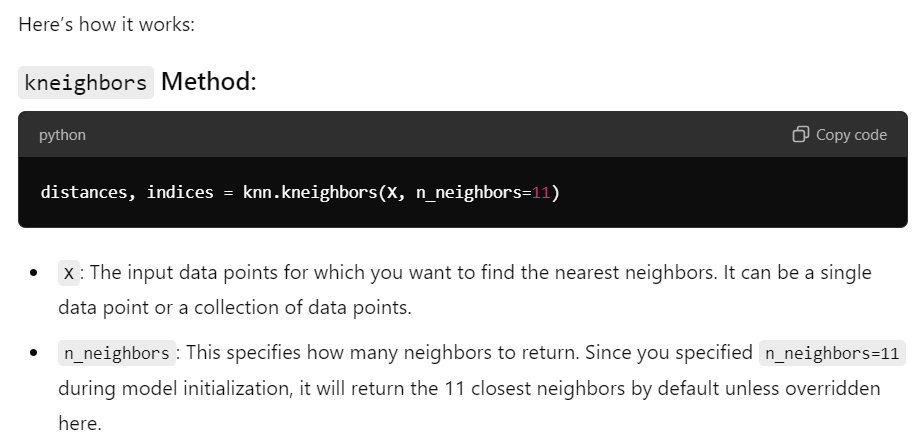

### *Input data(x) in this case look like below:*

In [46]:
# print(csr_data[5])

## <span style="color: pink;">Testing out movies </span>

In [47]:
get_movie_recommendation("Avengers 2012")

{'The Avengers (2012)': '0.0',
 'Guardians of the Galaxy (2014)': '164.0',
 'Iron Man 2 (2010)': '168.0',
 'Captain America: The Winter Soldier (2014)': '172.0',
 'X-Men: Days of Future Past (2014)': '177.0',
 'X-Men: First Class (2011)': '178.0',
 'Avengers: Age of Ultron (2015)': '181.0',
 'Captain America: The First Avenger (2011)': '182.5',
 'Iron Man 3 (2013)': '183.0',
 'Thor (2011)': '187.5',
 'Ant-Man (2015)': '195.5'}

## <span style="color: pink;"> Valid movie recommender </span>

#### <span style="color: #b4eb34;"> This section is to get a count of recommendations we recieve for each movie. This is to make the image scraping process more efficient by avoid downloading unnecessary pictures </span>

In [48]:
# creating a temporary dictionary to append data
temp_dict = {
    'Movie ID':[],
    'Movie Name':[],
    'Recommendations':[]
}

In [49]:
# # testing out the loop
# test_movie_list = movies['title'][0:10]
# # print(test_movie_list[2])
# get_movie_recommendation(test_movie_list[2])
# for movie in test_movie_list:
#     # print(movie)
#     try:
#         print(len(get_movie_recommendation(movie)))
#     except:
#         print("No Recommendations")

In [50]:
# # running through the actual loop

# movie_id_list = movies['movieId']
# movie_list = movies['title']

In [51]:
# count = 0
# for movie,movie_id in zip(movie_list,movie_id_list):
#     count += 1
#     # print(f"We are checking movie #{count}")
#     try:
#         temp_dict['Recommendations'].append(len(get_movie_recommendation(movie)))
#         temp_dict['Movie ID'].append(movie_id)
#         temp_dict['Movie Name'].append(movie)
#     except:
#         temp_dict['Recommendations'].append("NA")
#         temp_dict['Movie ID'].append(movie_id)
#         temp_dict['Movie Name'].append(movie)

#     if count % 100 == 0:
#         df = pd.DataFrame(data=temp_dict)
#         df.to_excel('valid_movies_w_recommendations.xlsx', index=False)
#         print("We are printing........")
#     else:
#         pass

In [52]:
# df = pd.DataFrame(data=temp_dict)
# df.to_excel('valid_movies_w_recommendations.xlsx', index=False)

## <span style="color: pink;"> Exporting a Pickle file of the KNN model</span>

In [53]:
# Assuming knn is your NearestNeighbors model
# with open('Saved Model/knn_model.pkl', 'wb') as f:
#     pickle.dump(knn, f)